In [105]:
import json
import logging
import math
import re
import time
import warnings
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval  # Safely evaluate a string that looks like a Python literal
from openai import OpenAI
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from typing import List, Dict, Any
import wbdata

# Suppress OpenAI cache logs
logging.getLogger("openai._base_client").setLevel(logging.ERROR)
logging.getLogger("shelved_cache").setLevel(logging.ERROR)
logging.getLogger("shelved_cache.persistent_cache").setLevel(logging.ERROR)
logging.getLogger('shelved_cache.persistent_cache').setLevel(logging.ERROR)

# Suppress Python warnings
warnings.filterwarnings('ignore')


## Business Understanding

In [11]:
import tiktoken

# Use OpenAI tokenizer to calculate token lengths (optional, more accurate)
def estimate_token_count(text, model="gpt-3.5-turbo-instruct"):
    enc = tiktoken.encoding_for_model(model)
    return len(enc.encode(text))

In [12]:
wbdata.get_sources()

  id  name
----  --------------------------------------------------------------------
   1  Doing Business
   2  World Development Indicators
   3  Worldwide Governance Indicators
   5  Subnational Malnutrition Database
   6  International Debt Statistics
  11  Africa Development Indicators
  12  Education Statistics
  13  Enterprise Surveys
  14  Gender Statistics
  15  Global Economic Monitor
  16  Health Nutrition and Population Statistics
  18  IDA Results Measurement System
  19  Millennium Development Goals
  20  Quarterly Public Sector Debt
  22  Quarterly External Debt Statistics SDDS
  23  Quarterly External Debt Statistics GDDS
  25  Jobs
  27  Global Economic Prospects
  28  Global Financial Inclusion
  29  The Atlas of Social Protection: Indicators of Resilience and Equity
  30  Exporter Dynamics Database – Indicators at Country-Year Level
  31  Country Policy and Institutional Assessment
  32  Global Financial Development
  33  G20 Financial Inclusion Indicators
  34  Glob

In [13]:
available_indicators = wbdata.get_indicators(source=2)
print(f'Total number of inficators {len(available_indicators)}')

Total number of inficators 1509


Prompt to retrieve the best indicators for our analysis

In [184]:
base_prompt = """
You are a data scientist responsible for selecting the most relevant development indicators to help predict when a country will reach the GDP per capita level typical of developed nations.

Below is a list of available indicators retrieved from the World Bank. Each item contains an indicator code and its corresponding name. You must select exactly {number_of_indicators_per_chunk} indicators from this list:

{chunked_indicators}

Your task:
- Choose indicators that are strongly associated with GDP growth, economic development, or structural transformation (e.g., education, infrastructure, industrialization, trade, institutions).
- Give preference to leading indicators or those with potential causal impact on development and health.
- Ensure diversity across key domains: macroeconomy, infrastructure, education, health, technology, labor, and governance.
- Add life expectancy at birth indicator
- Avoid indicators that are too similar to each other.
- Avoid indicators that are too generic or vague.
- Do not select indicators that are directly correlated with GDP.    
- Select exactly {number_of_indicators_per_chunk} indicators — do not exceed this number.
- Do not select any indicator related to CPIA.
- The resulting dictionary must contain exactly {number_of_indicators_per_chunk} key-value pairs.

Output format:
- Return a valid Python dictionary where each key is an indicator code and each value is a concise, cleaned summary of the indicator's meaning.
- Clean indicator names by removing special characters, keeping only letters, spaces, and the '%' symbol.
- Do not include code fences, markdown formatting, comments, or line breaks.
- make sure the dictionary is valid JSON.
- Do not include any additional text or explanations.  
- End the last character with a closing curly brace.
- Output only the dictionary in a single line, formatted like that:

{{"CODE1": "Abstract indicator meaning 1", "CODE2": "Abstract indicator meaning 2"}}
"""

Since we are going to use an LLM to retrieve the most relevant indicators and the list of available indicators is quite large, we need to create chunks to use with our LLM model without encountering any prompt size issues.

In [185]:

available_indicators = wbdata.get_indicators(source=2)  

df_indicators = pd.DataFrame(available_indicators)[['id', 'name']]

enc = tiktoken.encoding_for_model("gpt-3.5-turbo-instruct")
df_indicators["token_count"] = df_indicators["name"].apply(lambda x: len(enc.encode(x)))

base_prompt_count = estimate_token_count(base_prompt)
model_max_tokens = 1000  # Model's maximum context length is 4097 tokens
max_prompt_tokens = model_max_tokens - base_prompt_count
chunk_index = []

current_index = 0
for i in range(1, len(df_indicators)):
    if not chunk_index:
        list_indicators = "\n".join(
            (df_indicators["id"][0:i] + ": " + df_indicators["name"][0:i]).tolist()
        )
        token_count = estimate_token_count(list_indicators)
    else:
        list_indicators = "\n".join(
            (df_indicators["id"][current_index:i] + ": " + df_indicators["name"][current_index:i]).tolist()
        )
        token_count = estimate_token_count(list_indicators)
    
    if token_count > max_prompt_tokens:
        current_index = i
        chunk_index.append(i)
        token_count = 0

list_indicators = (df_indicators["id"] + ": " + df_indicators["name"]).tolist()

chunks = [
    list_indicators[0:index] if i == 0
    else list_indicators[chunk_index[i - 1]:index]
    for i, index in enumerate(chunk_index)]


In [186]:
def load_credentials(file_path: str) -> dict:
    """Load API credentials from a JSON file."""
    with open(file_path, "r") as file:
        return json.load(file)


def query_openai(
    prompt: str,
    model: str = "gpt-3.5-turbo-instruct",
    temperature: float = 0.0,
    max_tokens: int = 300,
    delay_seconds: int = 5,
) -> str:
    """
    Query OpenAI's API with the given prompt and return the response.

    Args:
        prompt: Input text for the model.
        model: OpenAI model to use.
        temperature: Controls randomness (0 = deterministic).
        max_tokens: Maximum length of the response.
        delay_seconds: Delay to prevent rate limiting.

    Returns:
        The generated text response.
    """
    response = client.completions.create(
        model=model,
        prompt=prompt,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    time.sleep(delay_seconds)  # Rate limiting
    return response.choices[0].text


# Load credentials and initialize client
credentials = load_credentials("credentials.json")
client = OpenAI(
    api_key=credentials["OPENAI_API_KEY"],
    base_url=credentials["OPENAI_API_BASE"],
)

In [187]:
def build_prompt(chunk: List[str], number_of_indicators: int, base_prompt: str) -> str:
    """
    Builds a prompt string by joining the chunk and formatting it with the given parameters.

    Args:
        chunk (List[str]): A list of indicator strings.
        number_of_indicators (int): Number of indicators per chunk.
        base_prompt (str): Prompt template string with placeholders.

    Returns:
        str: Formatted prompt string ready for model querying.
    """
    chunk_text = "\n".join(chunk)
    return base_prompt.format(
        chunked_indicators=chunk_text,
        number_of_indicators_per_chunk=number_of_indicators
    )


def extract_dict_from_response(response_text: str) -> Dict[str, Any]:
    """
    Extracts a dictionary from the raw model response, even if assigned to a variable like 'dict_indicators = {...}'.
    Tries literal_eval, then falls back to json.loads if necessary.

    Args:
        response_text (str): Raw model output text.

    Returns:
        Dict[str, Any]: Parsed dictionary.

    Raises:
        ValueError: If no dictionary is found or parsing fails.
    """
    import re
    import json
    from ast import literal_eval

    # Clean up the response text by removing unwanted characters (like newlines, tabs)
    clean_text = response_text.replace('\r', '').replace('\n', '').replace('\t', '').strip()

    # Ensure the string starts and ends with curly braces (indicating it's a dictionary)
    if not clean_text.startswith("{"):
        clean_text = "{" + clean_text
    if not clean_text.endswith("}"):
        clean_text += "}"

    # Extract the first dictionary-like string in the response
    match = re.search(r"\{.*\}", clean_text, re.DOTALL)
    if not match:
        print("DEBUG: Model response was:")
        print(repr(response_text))
        print(match)
        raise ValueError("No dictionary found in model response.")

    raw_dict_text = match.group(0)

    # First, attempt to parse the dictionary using literal_eval
    try:
        return literal_eval(raw_dict_text)
    except Exception as e:
        print(f"Error during literal_eval: {e}")
        # If literal_eval fails, attempt to parse using json.loads
        try:
            return json.loads(raw_dict_text)
        except Exception as e:
            print(f"Error during json.loads: {e}")
            # Raise a ValueError if both methods fail
            raise ValueError(f"Failed to parse dictionary using both literal_eval and json.loads: {e}")

def process_chunk(
    idx: int,
    chunk: List[str],
    number_of_indicators: int,
    base_prompt: str,
    retries: int = 3
) -> Dict[str, Any]:
    """
    Processes a single chunk of indicators by querying the model and extracting the resulting dictionary.

    Args:
        idx (int): Index of the current chunk (for logging).
        chunk (List[str]): List of indicator strings in this chunk.
        number_of_indicators (int): Number of indicators per chunk.
        base_prompt (str): Prompt template string with placeholders.
        retries (int, optional): Number of retry attempts on failure. Defaults to 3.

    Returns:
        Dict[str, Any]: Dictionary of processed indicators from the model response.
    """
    print(f"\nRunning chunk {idx + 1}/{len(chunks)}...")

    prompt = build_prompt(chunk, number_of_indicators, base_prompt)

    for attempt in range(1, retries + 1):
        try:
            print(f"Attempt {attempt}...", end=" ")
            response_text = query_openai(prompt)  # Now expects a plain string
            print("Success.")
            return extract_dict_from_response(response_text)
        except Exception as e:
            print(response_text)
            print(f"Error: {e}")
            if attempt < retries:
                time.sleep(5)
            else:
                print(f"Failed chunk {idx + 1} after {retries} attempts.")
                return {}  # Optionally log or escalate


def run_all_chunks(
    chunks: List[List[str]],
    max_indicators: int,
    base_prompt: str
) -> Dict[str, Any]:
    """
    Processes all chunks of indicators and merges the resulting dictionaries.

    Args:
        chunks (List[List[str]]): List of chunks, where each chunk is a list of indicator strings.
        max_indicators (int): Maximum number of indicators to be distributed across chunks.
        base_prompt (str): Prompt template string with placeholders.

    Returns:
        Dict[str, Any]: Merged dictionary from all processed chunks.
    """
    n_chunks = len(chunks)
    number_of_indicators = math.ceil(max_indicators / n_chunks)

    merged_dict = {}
    for idx, chunk in enumerate(chunks):
        chunk_result = process_chunk(
            idx, chunk, number_of_indicators, base_prompt
        )
        merged_dict.update(chunk_result)

    return merged_dict


In [188]:
merged_dict = run_all_chunks(chunks, 300, base_prompt)


Running chunk 1/54...
Attempt 1... Success.

Running chunk 2/54...
Attempt 1... Success.

Running chunk 3/54...
Attempt 1... Success.

Running chunk 4/54...
Attempt 1... Success.

Running chunk 5/54...
Attempt 1... Success.

Running chunk 6/54...
Attempt 1... Success.

Running chunk 7/54...
Attempt 1... Success.

Running chunk 8/54...
Attempt 1... Success.

Running chunk 9/54...
Attempt 1... Success.

Running chunk 10/54...
Attempt 1... Success.

Running chunk 11/54...
Attempt 1... Success.

Running chunk 12/54...
Attempt 1... Success.

Running chunk 13/54...
Attempt 1... Success.

Running chunk 14/54...
Attempt 1... Success.

Running chunk 15/54...
Attempt 1... Success.

Running chunk 16/54...
Attempt 1... Success.

Running chunk 17/54...
Attempt 1... Success.

Running chunk 18/54...
Attempt 1... Success.

Running chunk 19/54...
Attempt 1... Success.

Running chunk 20/54...
Attempt 1... Success.

Running chunk 21/54...
Attempt 1... Success.

Running chunk 22/54...
Attempt 1... Succes

Selecting just America countries

In [189]:
america_countries = [
    'ARG', 'BLZ', 'BOL', 'BRA', 'CHL', 'COL', 
    'CRI', 'ECU', 'SLV', 'GTM', 'GUY', 'HND', 'MEX', 
    'NIC', 'PAN', 'PRY', 'PER', 'SUR', 'URY', 'CAN','USA'
]

# Adding target variable
merged_dict.update({'NY.GDP.PCAP.CD':'GDP per capita (current US$)'})

df_combined = None

for key, value in merged_dict.items():
    try:
        data = wbdata.get_dataframe(
            {key: value},
            country=america_countries,
            date=("2000", "2023")
        )

        if df_combined is None:
            df_combined = data
        else:
            df_combined = pd.concat([df_combined, data], axis=1)

    except Exception:
        continue  

df_combined.reset_index(inplace = True)
# df.dropna(inplace=True)
df_combined.to_csv('df_indicators.csv',index=False)
# df  = pd.read_csv('df_indicators.csv',index_col=0)

## Data Understanding


In [190]:
df_combined.shape

(504, 279)

In [191]:
def mull_heat_map(df, column_to_group):
    """
    Generates a heatmap showing the null rate of each column 
    grouped by a specified column (e.g., country, year).

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    column_to_group (str): The column name by which to group the data 
                           before calculating null rates.
    """
    # Calculate null rate by group and transpose for visualization
    null_rates = df.groupby(column_to_group).apply(lambda x: x.isnull().mean())
    null_rates = null_rates.T

    # Plot heatmap
    plt.figure(figsize=(30, 30))
    sns.heatmap(
        null_rates,
        cmap='YlOrRd',
        annot=True,
        fmt='.1%',
        linewidths=0.5,
        cbar_kws={'label': 'Null Rate'}
    )

    # Set plot titles and labels
    plt.title(f'Null Rate by {column_to_group}', fontsize=12)
    plt.ylabel('Variable', fontsize=12)

    # Customize axis ticks
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

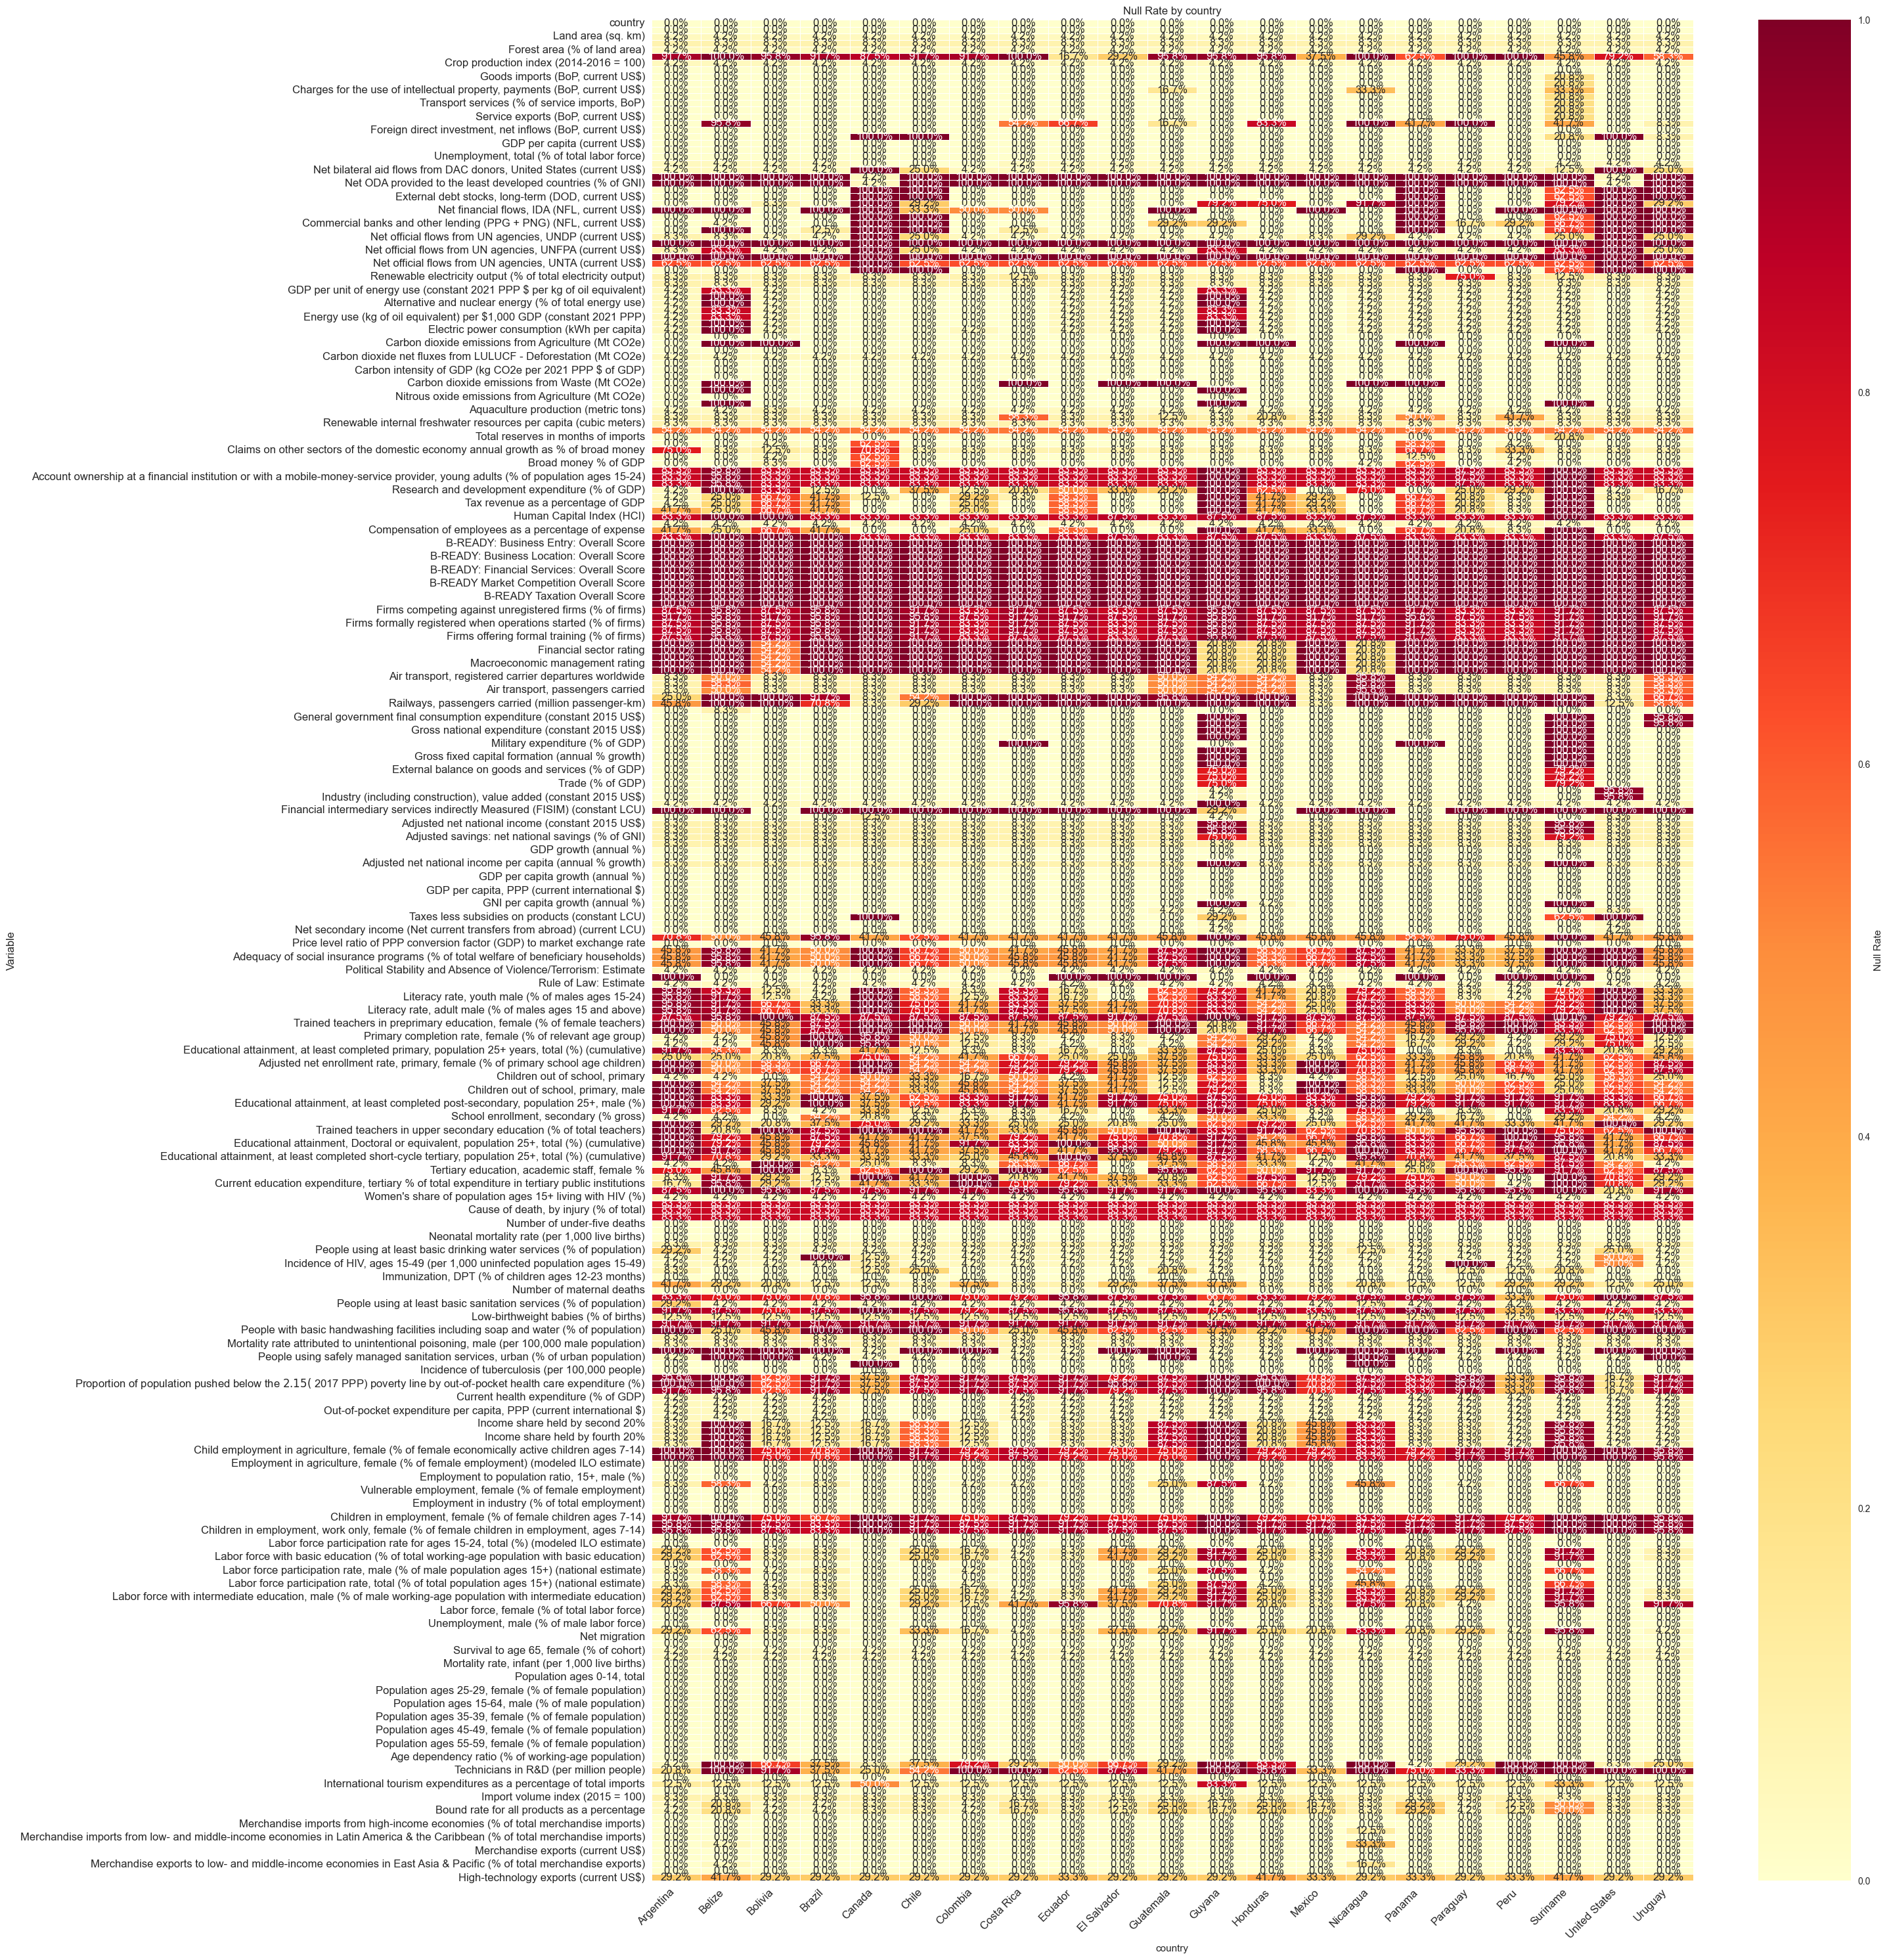

In [192]:
mull_heat_map(df_combined,'country')

It is possible to see that the some indicators are not good, since most of its values are null

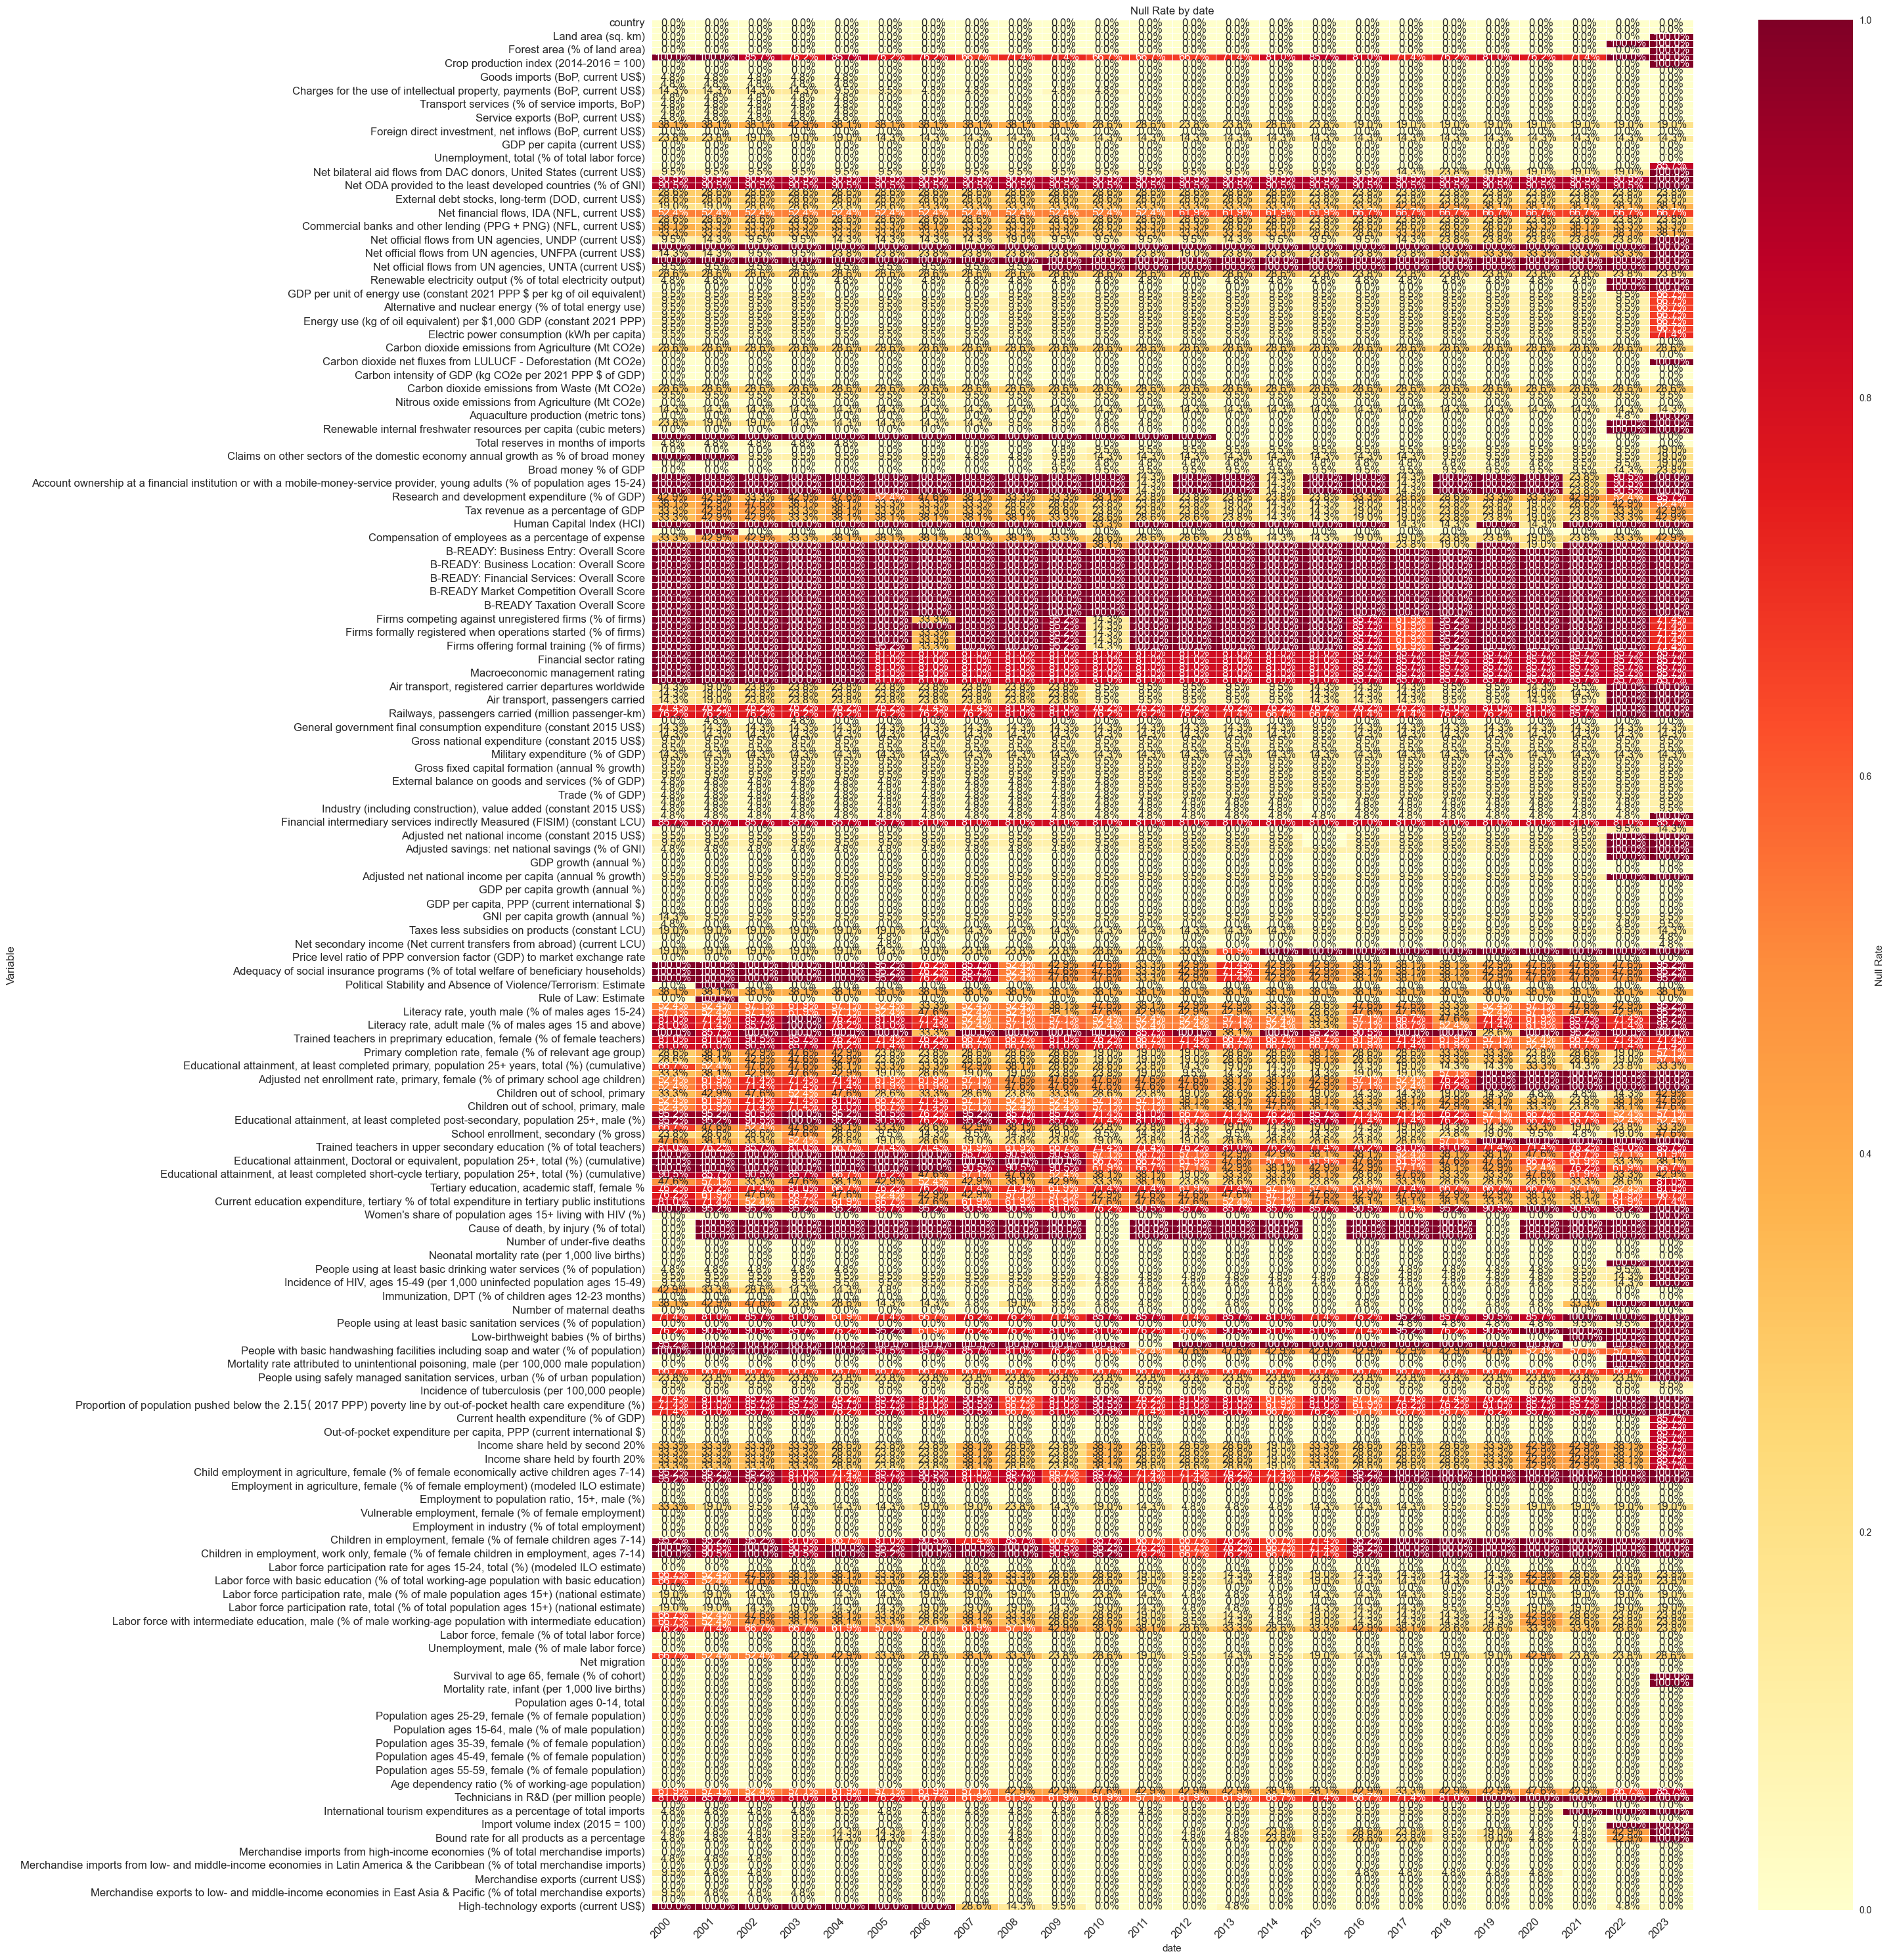

In [193]:
mull_heat_map(df_combined,'date')

For this heat maps, we can see that the Mortality rate atributed to unsafe water and b-ready related indicators are not good indicators for us, as many others with higher percentage of missing values, since in many years we dont have any values in it, so we need to change that.

## Data Preprocessing

In [194]:
# Define missingness threshold
threshold = 0.4  # 40% of missingness

# Calculate null rates per country (excluding the 'country' column from results)
null_rates_country = (
    df_combined.groupby(['country'])
    .apply(lambda x: x.isnull().mean())
    .drop(columns=['country'])
    .reset_index()
)

# Initialize list to store columns to drop
columns_not_to_keep = []

# Loop through each country and check null rates for each column
for country in null_rates_country['country'].unique():
    country_data = null_rates_country[null_rates_country['country'] == country]

    for column in null_rates_country.columns[2:]:  # Skip 'country' and first data column
        null_rate = country_data[column].values[0]

        if null_rate > threshold and column not in columns_not_to_keep:
            columns_not_to_keep.append(column)

In [195]:
# Keep only columns that are not in the exclusion list
columns_to_keep = [col for col in df_combined.columns if col not in columns_not_to_keep]

# Display summary of dropped and retained columns
print(f'Columns that have been dropped: {columns_not_to_keep}')
print(f'Quantity of indicators dropped: {len(columns_not_to_keep)}')
print(f'Quantity of kept indicators: {len(columns_to_keep)}')

# Create filtered DataFrame
df_filtered = df_combined[columns_to_keep]

Columns that have been dropped: ['Agricultural irrigated land (% of total agricultural land)', 'Net ODA provided, to the least developed countries (current US$)', 'Net ODA provided to the least developed countries (% of GNI)', 'Net financial flows, IDA (NFL, current US$)', 'Net official flows from UN agencies, UNECE (current US$)', 'Net official flows from UN agencies, UNIDIR (current US$)', 'Net official flows from UN agencies, UNTA (current US$)', 'Terrestrial and marine protected areas (% of total territorial area)', 'Claims on other sectors of the domestic economy annual growth as % of broad money', 'Account ownership at a financial institution or with a mobile-money-service provider, secondary education or more (% of population ages 15+)', 'Account ownership at a financial institution or with a mobile-money-service provider, young adults (% of population ages 15-24)', 'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)',

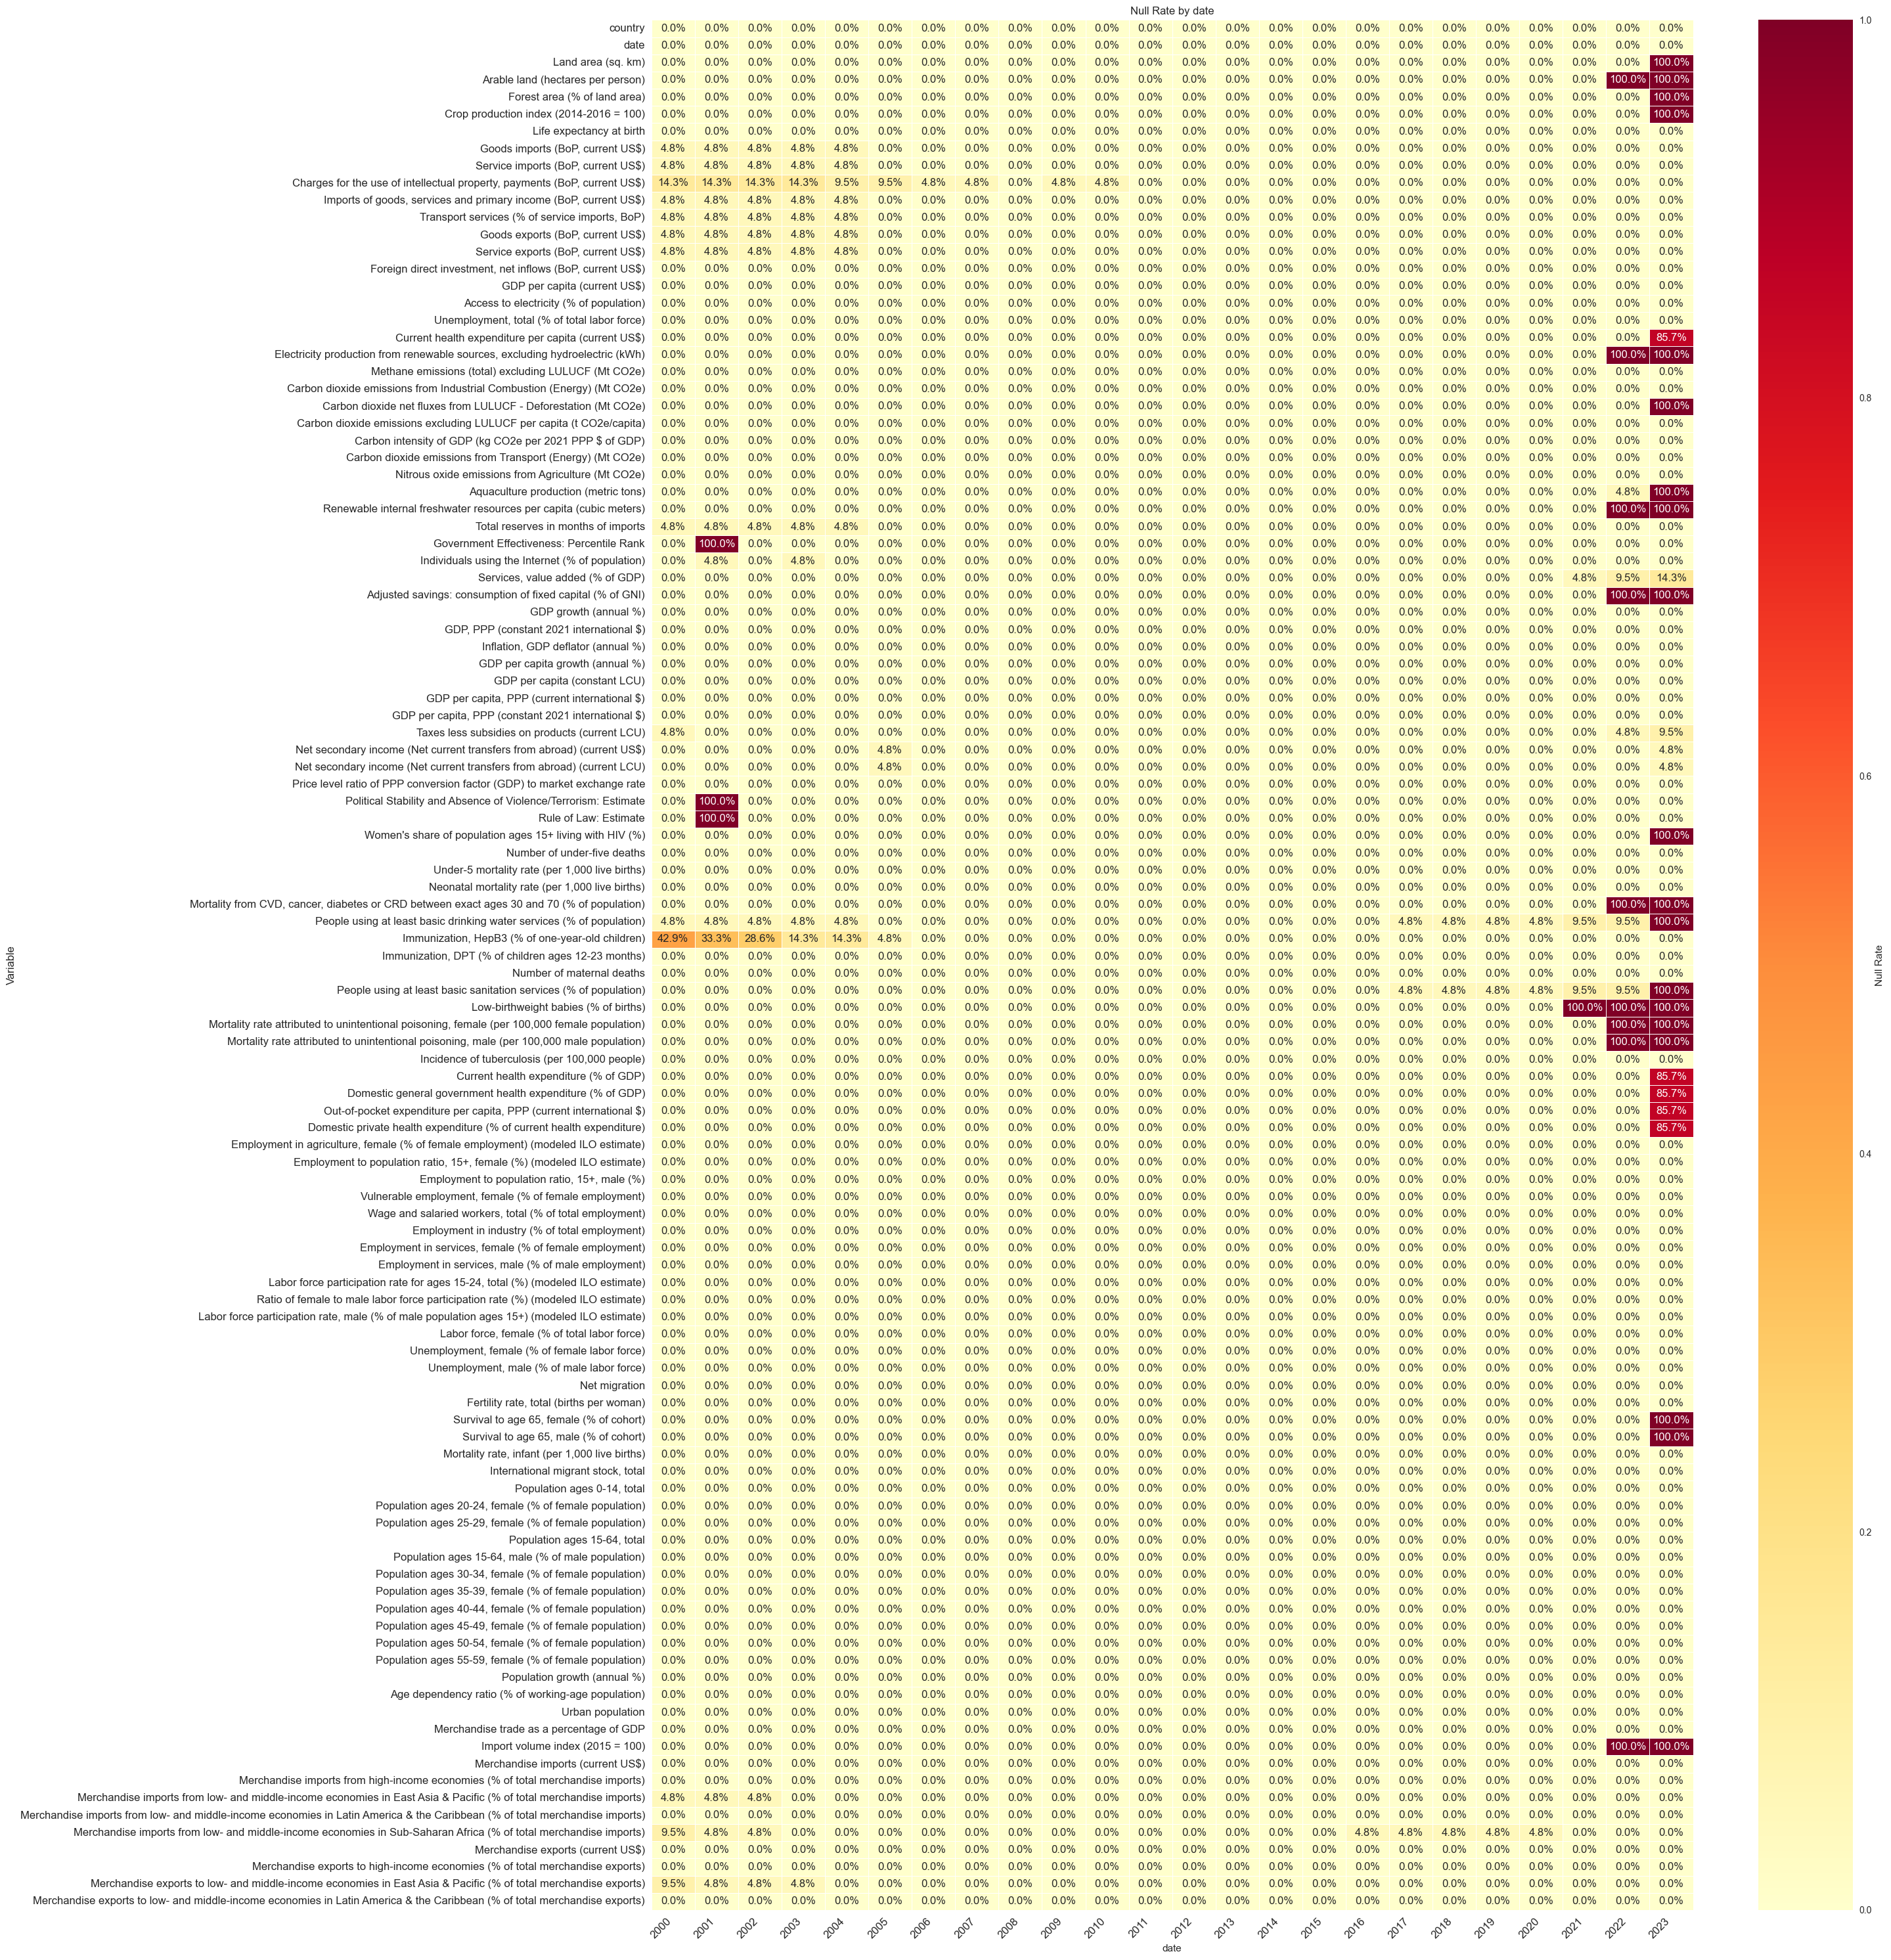

In [196]:
mull_heat_map(df_filtered,'date')

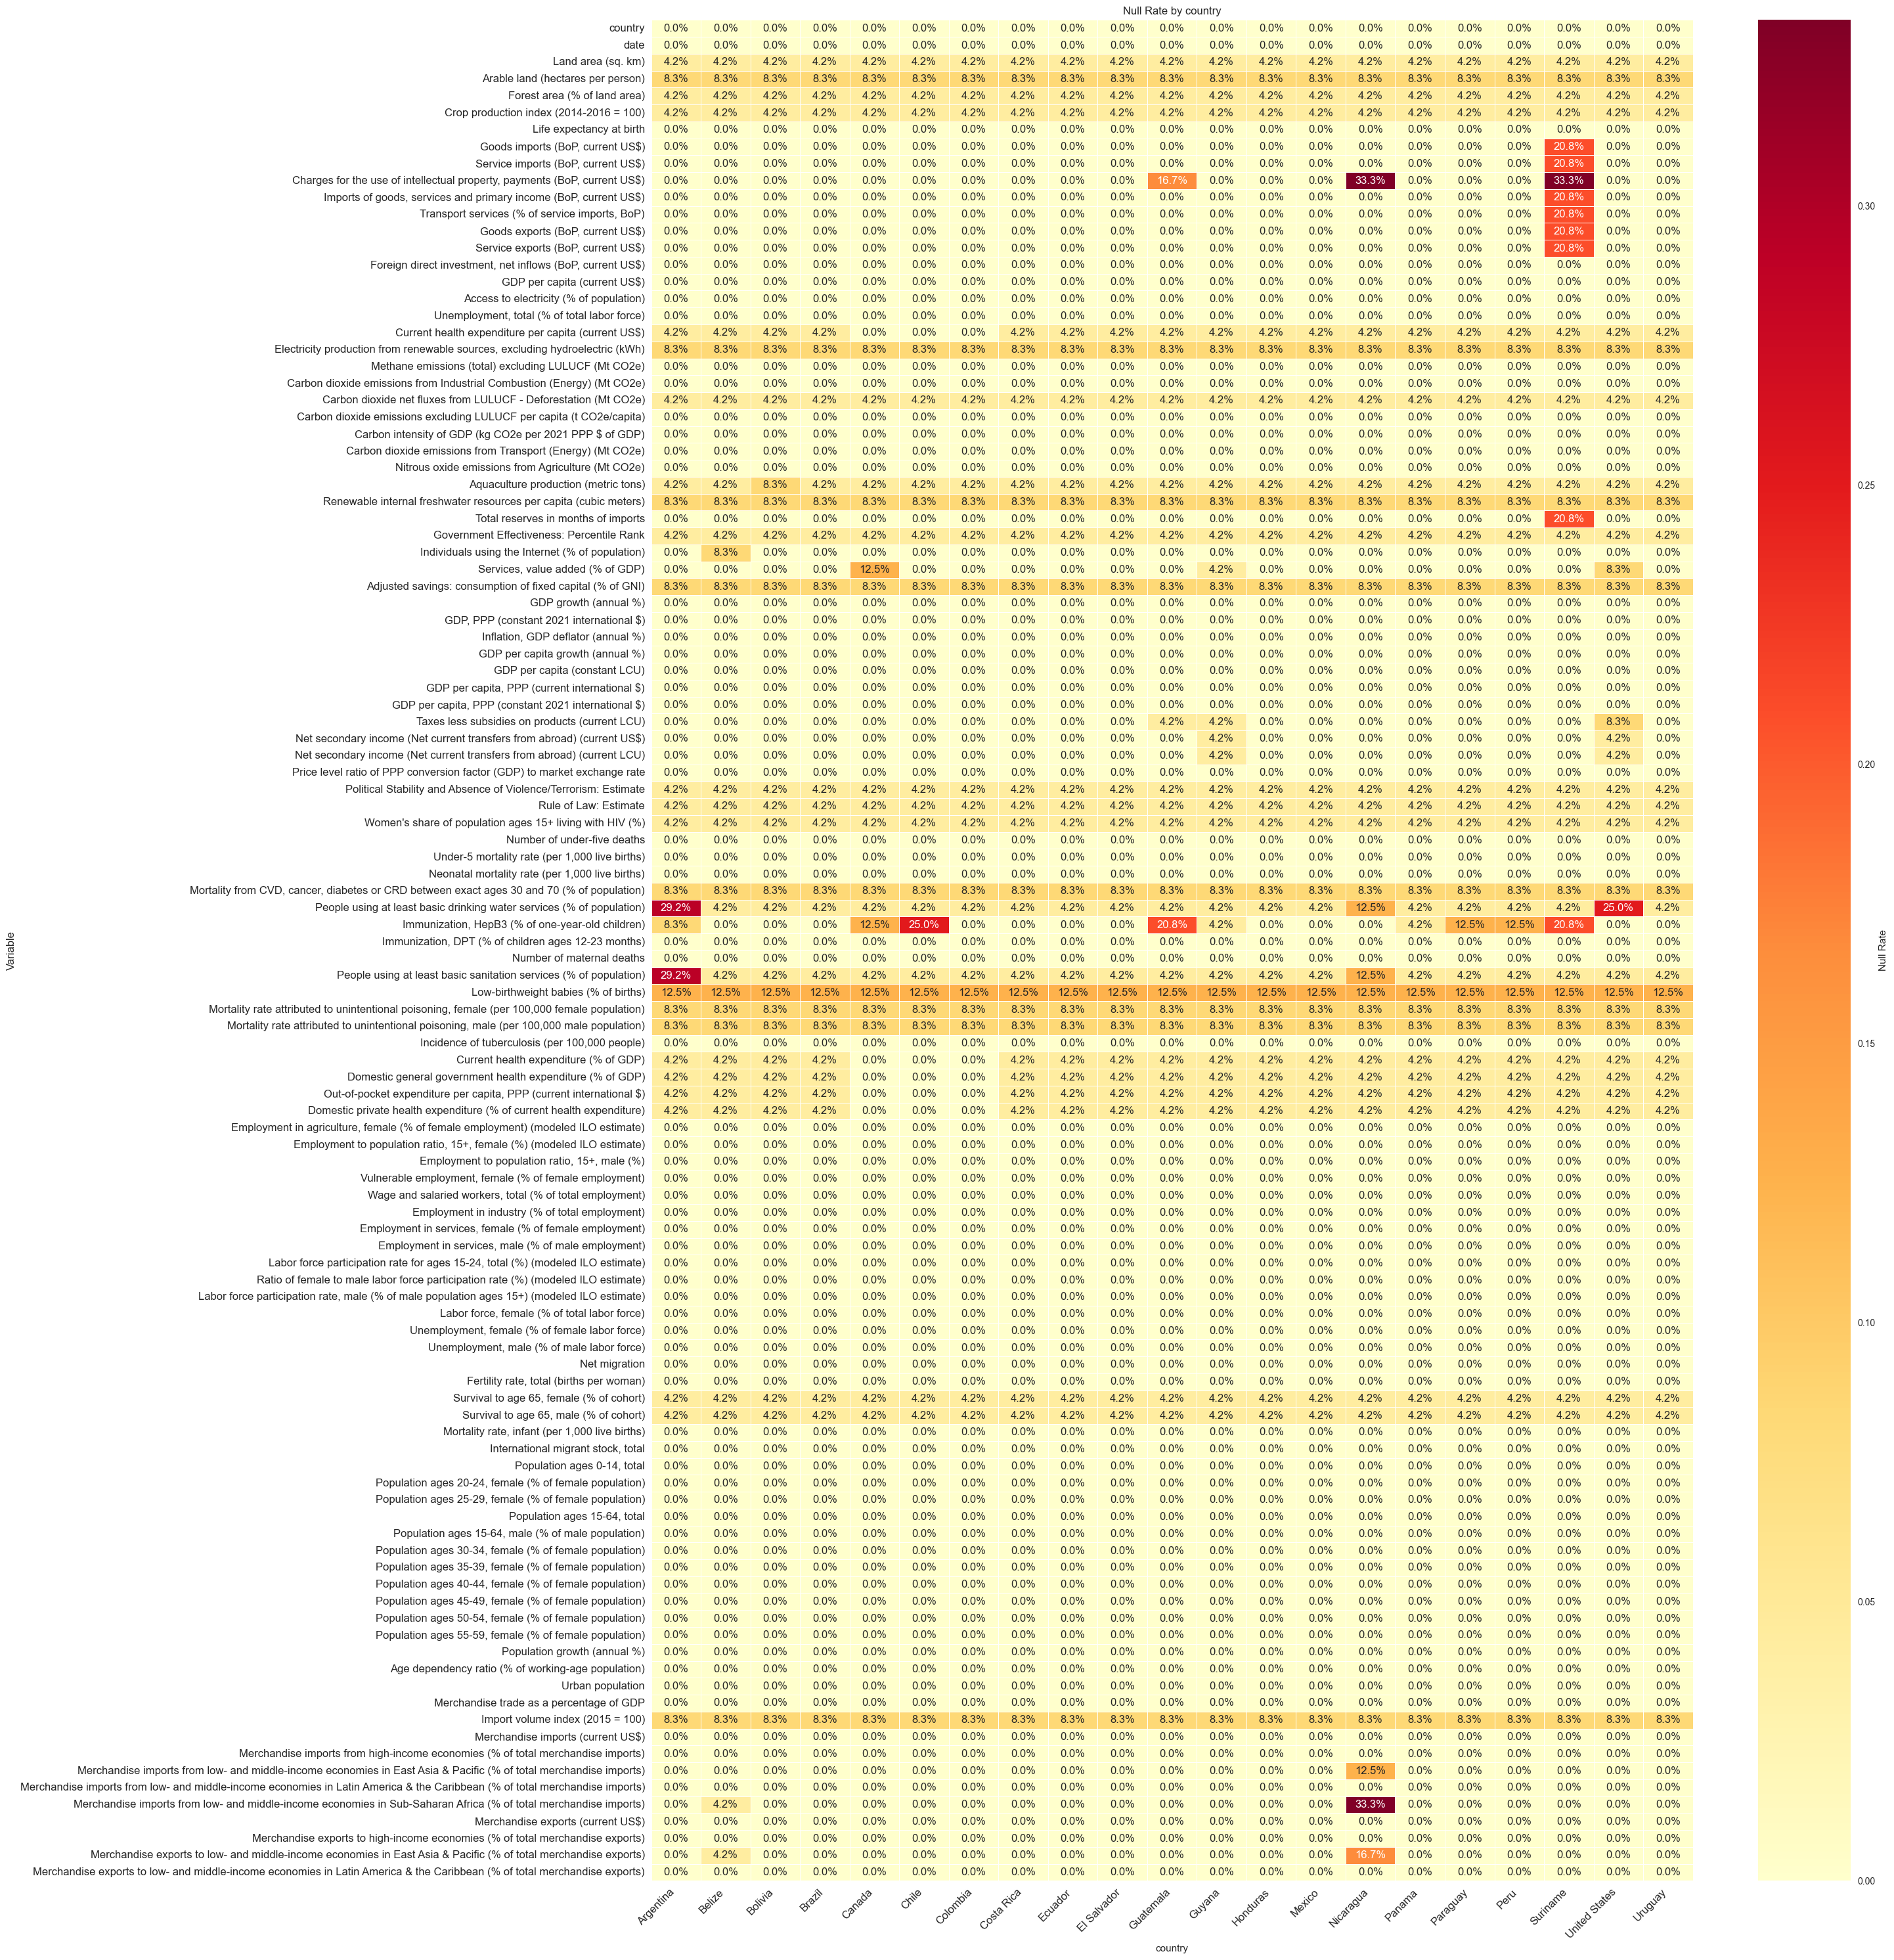

In [197]:
mull_heat_map(df_filtered,'country')

In [198]:
def imput_indicators_lr(df, country_col='country', year_col='date'):
    """
    Impute missing values in indicator columns using Linear Regression.

    Assumptions:
    1. All indicator columns are numeric.
    2. Year column is numeric.
    3. Each country-indicator combination has ≥ 2 data points.
    """
    # Ensure year column is numeric
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')

    # Identify indicator columns (exclude metadata columns)
    indicators = [
        col for col in df.columns
        if col not in {country_col, year_col}
    ]

    # Define function to impute missing values within each group
    def impute_group(group):
        for col in indicators:
            known = group[group[col].notna()]
            X = known[[year_col]]
            y = known[col]

            model = LinearRegression().fit(X, y)

            missing = group[col].isna()
            if missing.any():
                group.loc[missing, col] = model.predict(
                    group.loc[missing, [year_col]]
                )
        return group

    # Apply imputation by country
    return df.groupby(country_col, group_keys=False).apply(impute_group)

# Apply the imputation function to the filtered DataFrame
df_filtered_imputed = imput_indicators_lr(df_filtered)

In [199]:
def plot_indicator_by_country(df, indicator_name,x_axis='date'):
    """
    Plots the given indicator over time for each country in the DataFrame,
    with both a legend and the country name displayed at the end of each line.

    Parameters:
    - df: DataFrame containing 'country', 'date', and indicator columns
    - indicator_name: str, the name of the indicator to plot
    """
    plt.figure(figsize=(15, 10))

    for country in df['country'].unique():
        country_data = df[df['country'] == country]
        if indicator_name in country_data.columns and not country_data[indicator_name].isna().all():
            plt.plot(country_data[x_axis], country_data[indicator_name], label=country)
            # Add country name at the end of the line
            last_valid_index = country_data[indicator_name].last_valid_index()
            if last_valid_index is not None:
                x = country_data.loc[last_valid_index, x_axis]
                y = country_data.loc[last_valid_index, indicator_name]
                plt.text(x, y, f' {country}', fontsize=8, ha='left', va='center')

    plt.title(f'{indicator_name} by {x_axis}')
    plt.xlabel(x_axis)
    plt.ylabel(indicator_name)
    plt.legend(title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


## Data Modeling

### Business questions

- 1 😷 Did the COVID-19 pandemic (2020–2022) affect the life expectancy at birth across the Americas?
- 2 🧑‍🌾 Which country had the highest GDP growth during this period?
- 3 🌎 How can we group countries in the Americas based on their post-pandemic socioeconomic and health recovery patterns (2020–2022) to identify investment priorities for international development organizations?

- Did the COVID-19 pandemic (2020–2022) affect the life expectancy at birth across the Americas?

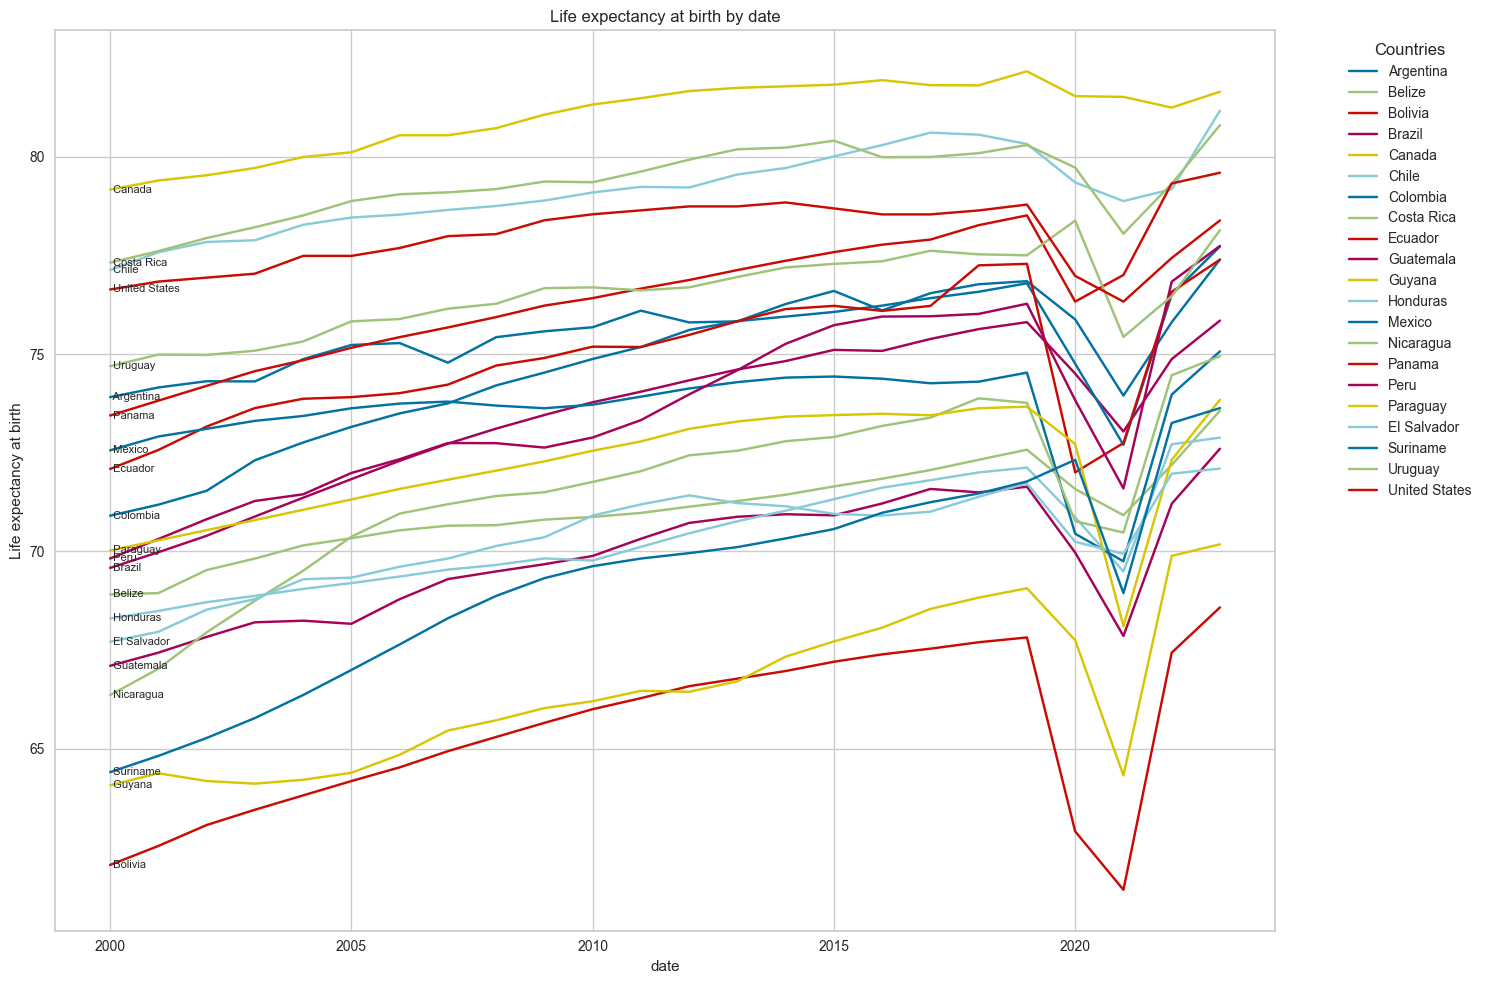

In [207]:
plot_indicator_by_country(df_filtered_imputed,'Life expectancy at birth')

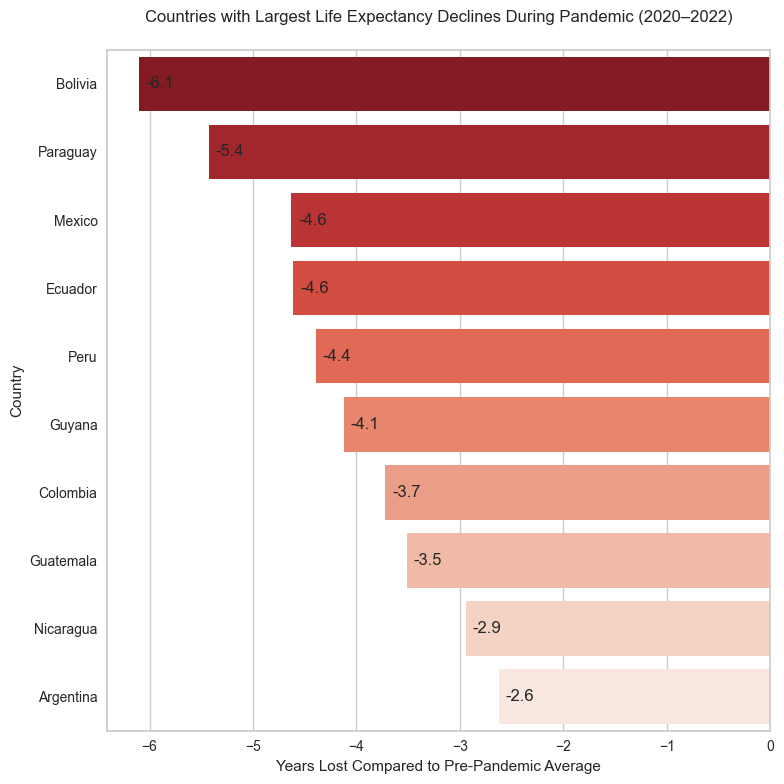

In [212]:
# Pivot table for easier analysis
life_exp_pivot = df_filtered_imputed.pivot(
    index='country',
    columns='date',
    values='Life expectancy at birth'
)

# Get pre-pandemic baseline (average of 2015–2019)
life_exp_pivot['pre_pandemic_avg'] = life_exp_pivot.loc[:, 2015:2019].mean(axis=1)

# Calculate change in life expectancy during pandemic years
for year in [2020, 2021, 2022]:
    life_exp_pivot[f'delta_{year}'] = (
        life_exp_pivot[year] - life_exp_pivot['pre_pandemic_avg']
    )

# Get the largest decline observed during the pandemic
life_exp_pivot['max_decline'] = life_exp_pivot[
    [f'delta_{y}' for y in [2020, 2021, 2022]]
].min(axis=1)

# Prepare plot
plt.figure(figsize=(8, 8))

# Select top 10 countries with the largest life expectancy decline
top_declines = life_exp_pivot.nsmallest(10, 'max_decline')
top_declines = top_declines.sort_values('max_decline')

# Create bar plot
ax = sns.barplot(
    data=top_declines,
    y=top_declines.index,
    x='max_decline',
    palette='Reds_r'
)

# Set plot titles and labels
plt.title(
    'Countries with Largest Life Expectancy Declines During Pandemic (2020–2022)',
    pad=20
)
plt.xlabel('Years Lost Compared to Pre-Pandemic Average')
plt.ylabel('Country')

# Add value labels to each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.1f}",
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left',
        va='center',
        xytext=(5, 0),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()


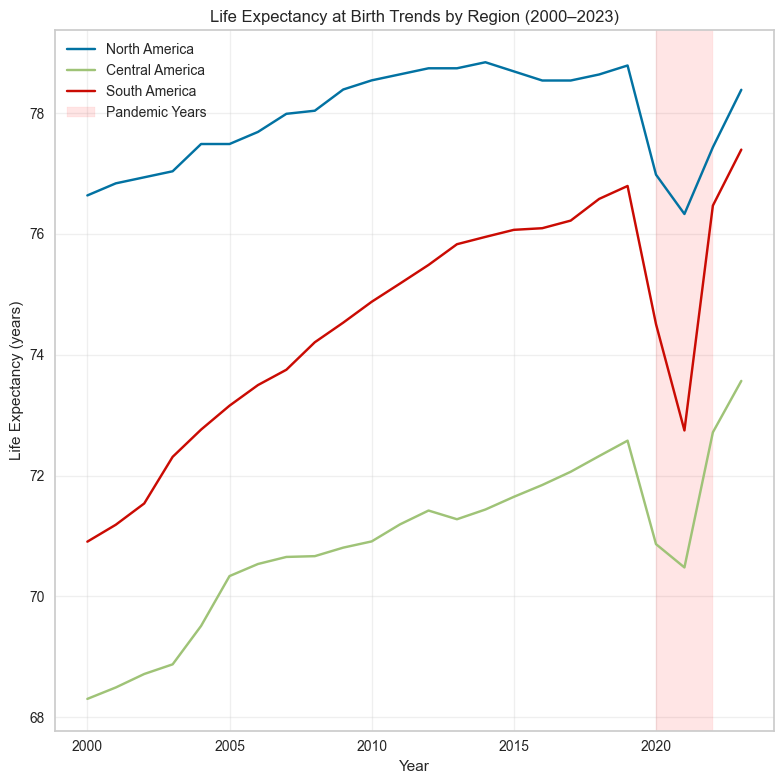

In [213]:
# Calculate regional averages
americas_regions = {
    'North America': ['United States', 'Canada', 'Mexico'],
    'Central America': ['Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua', 'Panama'],
    'South America': ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Paraguay', 'Peru', 'Uruguay']
}


# Create plot
plt.figure(figsize=(8, 8))

# Plot life expectancy trends by region
for region, countries in americas_regions.items():
    region_df = df_filtered_imputed[
        df_filtered_imputed['country'].isin(countries)
    ]
    sns.lineplot(
        data=region_df,
        x='date',
        y='Life expectancy at birth',
        label=region,
        ci=None,
        estimator='median'
    )

# Customize plot appearance
plt.title('Life Expectancy at Birth Trends by Region (2000–2023)')
plt.xlabel('Year')
plt.ylabel('Life Expectancy (years)')
plt.axvspan(2020, 2022, color='red', alpha=0.1, label='Pandemic Years')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Answer to the first question:** Yes, the COVID-19 pandemic affected life expectancy, particularly in South American countries like Bolivia, Paraguay, and Ecuador. The chart Life Expectancy at Birth Trends by Region (2000–2023) shows that countries from South America had less reliable healthcare systems or were more affected by the pandemic compared to countries from North and Central America. Despite this, it is clear that Central American countries generally have lower life expectancy overall.

- Which country had the highest GDP growth during this period?

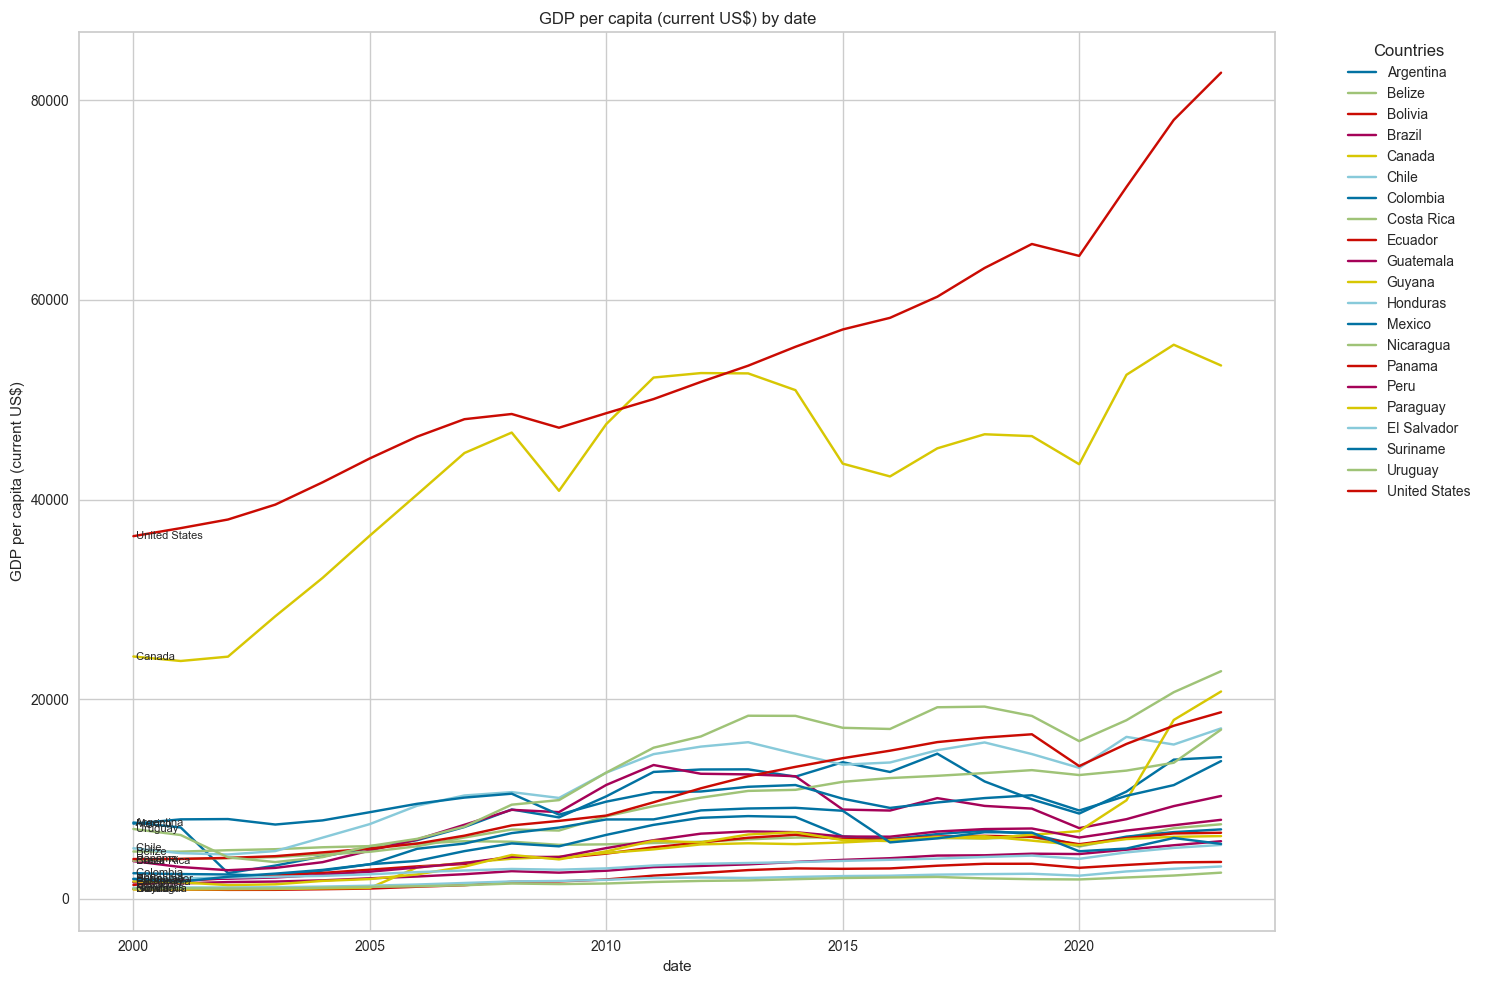

In [214]:
plot_indicator_by_country(df_filtered_imputed,'GDP per capita (current US$)')

In [215]:
# Keep only the needed columns
growth_df = df_filtered_imputed[
    ['country', 'date', 'GDP per capita (current US$)']
]

# Get the min and max year in the dataset
max_year = growth_df['date'].max()
min_year = growth_df['date'].min()

# Sort by country
growth_df = growth_df.sort_values(by='country')

# Get GDP values for min and max year
gdp_max = growth_df[growth_df['date'] == max_year]['GDP per capita (current US$)'].values
gdp_min = growth_df[growth_df['date'] == min_year]['GDP per capita (current US$)'].values

# Compute GDP difference
gdp_diff = gdp_max - gdp_min

# Create DataFrame with differences
df_diff = pd.DataFrame.from_dict({
    'country': growth_df['country'].unique(),
    'gdp_max': gdp_max,
    'gdp_min': gdp_min,
    'gdp_diff': gdp_diff
})

# Calculate relative difference (percentage growth)
df_diff['gdp_diff_pct'] = (
    df_diff['gdp_max'] - df_diff['gdp_min']
) / df_diff['gdp_min']

# Sort by percentage growth descending
df_diff.sort_values(by='gdp_diff_pct', ascending=False, inplace=True)


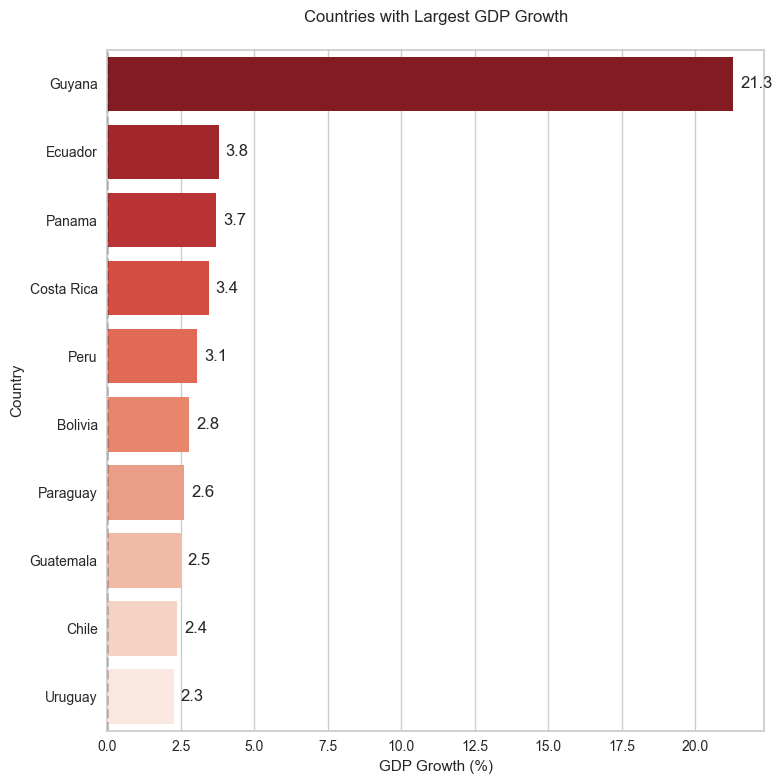

In [216]:
plt.figure(figsize=(8, 8))

# Top 10 countries with the highest GDP growth percentage
max_gdp_growth_pct = df_diff.nlargest(10, 'gdp_diff_pct').sort_values(
    'gdp_diff_pct', ascending=False
)

# Create horizontal bar plot
ax = sns.barplot(
    data=max_gdp_growth_pct,
    y='country',
    x='gdp_diff_pct',
    palette='Reds_r'
)

plt.title('Countries with Largest GDP Growth', pad=20)
plt.xlabel('GDP Growth (%)')
plt.ylabel('Country')
plt.axvline(0, color='black', linestyle='--')

# Add value labels to bars
for patch in ax.patches:
    ax.annotate(
        f"{patch.get_width():.1f}",
        (patch.get_width(), patch.get_y() + patch.get_height() / 2),
        ha='left',
        va='center',
        xytext=(5, 0),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()


**Answer to the second question:** The United States and Canada clearly stand out with the highest GDP per capita among all countries in the Americas, as shown in the first graph. Their economic development is significantly ahead of the rest, with the U.S. surpassing $80,000 and Canada above $50,000 in recent years. This reflects their well-established economies and high standards of living.

In contrast, the first graph highlights the countries with the highest  GDP growth rates between 2000 and 2023. Guyana leads by a wide margin, with over 21% annual GDP growth—a remarkable figure. This rapid expansion is largely attributed to recent offshore oil discoveries, which have transformed its economic prospects. Other countries like Ecuador, Panama, and Costa Rica also show solid growth, though much more modest in comparison.

- How can we group countries in the Americas based on their post-pandemic socioeconomic and health recovery patterns (2020–2022) to identify investment priorities for international development organizations?

In [217]:
# Create a copy of the filtered dataset
df = df_filtered_imputed.copy()

# 1. Filter to the most recent year
target_year = df['date'].max()
df_latest = df[df['date'] == target_year].copy()

# 2. Select all numeric features (excluding 'country' and 'date') for PCA
features = [col for col in df_latest.columns if col not in ['country', 'date']]
X = df_latest[features].values

# 3. Apply StandardScaler to normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # This centers and scales the data

# 4. Perform PCA on the scaled data
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
print("Explained variance per component:")
print(pca.explained_variance_ratio_)

Explained variance per component:
[3.43435423e-01 1.29280982e-01 1.15780993e-01 7.59092337e-02
 5.10341711e-02 4.16108146e-02 3.93557279e-02 3.27253533e-02
 2.97885124e-02 2.57863048e-02 2.22379447e-02 1.98452133e-02
 1.51584062e-02 1.19819318e-02 1.09023575e-02 9.31159882e-03
 7.60208387e-03 7.14008276e-03 6.48827123e-03 4.62459426e-03
 3.24952510e-33]


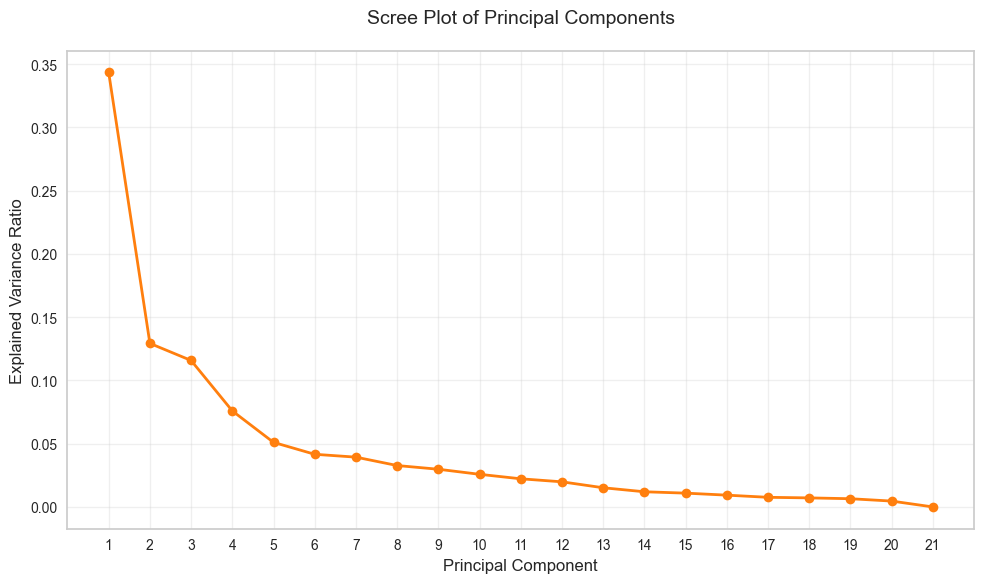

In [218]:
# Visualize the scree plot
plt.figure(figsize=(10, 6))

# Get colors from the tab10 colormap
colors = plt.get_cmap('tab10')

# Plot the explained variance ratio for each principal component
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_,
    'o-', 
    linewidth=2, 
    color=colors(1)  # Use first color from tab10 palette
)

# Set plot title and labels
plt.title('Scree Plot of Principal Components', fontsize=14, pad=20)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)

# Set x-ticks and grid
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True, alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [219]:
#Determine number of components to explain 90% variance
explained = pca.explained_variance_ratio_.cumsum()

# Find the number of components required to explain 90% of the variance
n_selected = (explained >= 0.9).argmax() + 1

# Print the result
print(f"Selecting top {n_selected} PCA components explaining {explained[n_selected - 1]:.2%} variance.")

# Select the top components
X_selected = X_pca[:, :n_selected]

Selecting top 11 PCA components explaining 90.69% variance.


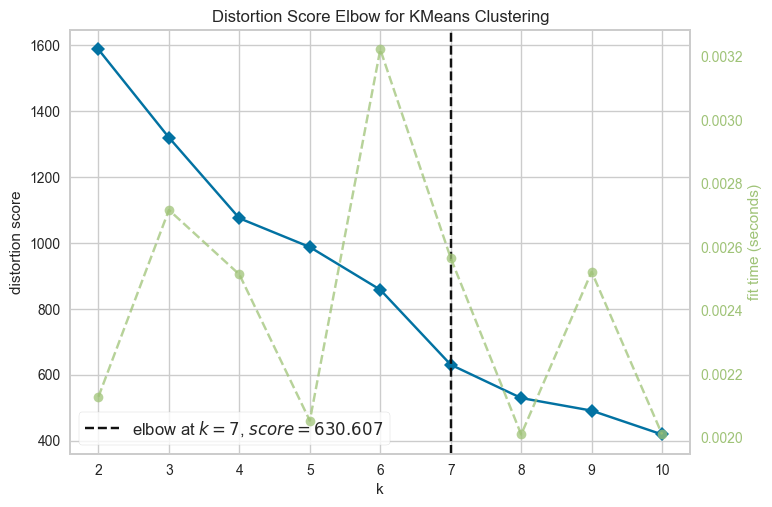

Best value using inertia: 7


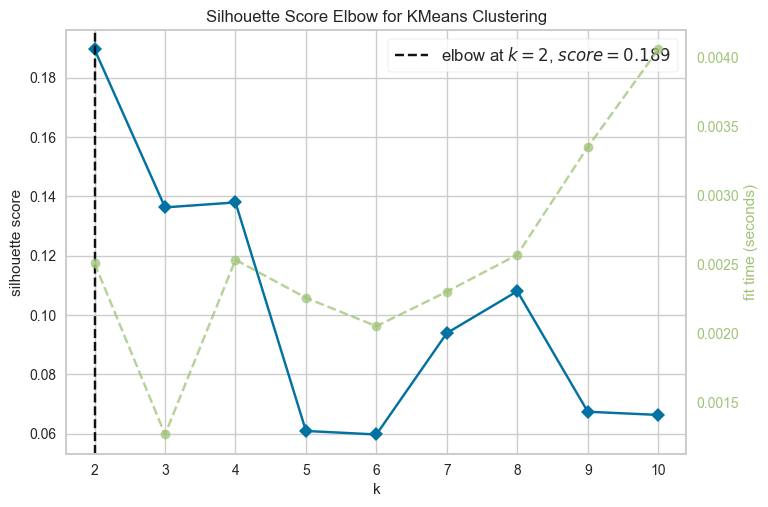

Best value using Silhouette: 2


In [220]:
# Inertia (Elbow) measures compactness (how close points are within clusters).
visualizer_inertia = KElbowVisualizer(KMeans(random_state=42), k=(2, 11), metric='distortion')
visualizer_inertia.fit(X_selected)
visualizer_inertia.show()
print(f'Best value using inertia: {visualizer_inertia.elbow_value_}')

# Silhouette measures the quality of separation between clusters.
visualizer_silhouette = KElbowVisualizer(KMeans(random_state=42), k=(2, 11), metric='silhouette')
visualizer_silhouette.fit(X_selected)
visualizer_silhouette.show()
print(f'Best value using Silhouette: {visualizer_silhouette.elbow_value_}')


I selected the Silhouette Score over the Elbow Method as the primary criterion for determining the optimal number of clusters. While the Elbow Method is useful for identifying the point where additional clusters result in smaller improvements in within-cluster variance (inertia), it does not directly account for how well-separated the clusters are. The Silhouette Score, by contrast, evaluates both cohesion within clusters and separation between clusters, providing a more robust indication of cluster validity. Although the Elbow Method suggested the use of 7 clusters, the Silhouette Score revealed that a 2-cluster solution offered better-defined and more interpretable groupings. Given the goal of maximizing interpretability and ensuring meaningful differentiation between clusters, the final decision was guided by the Silhouette Score.

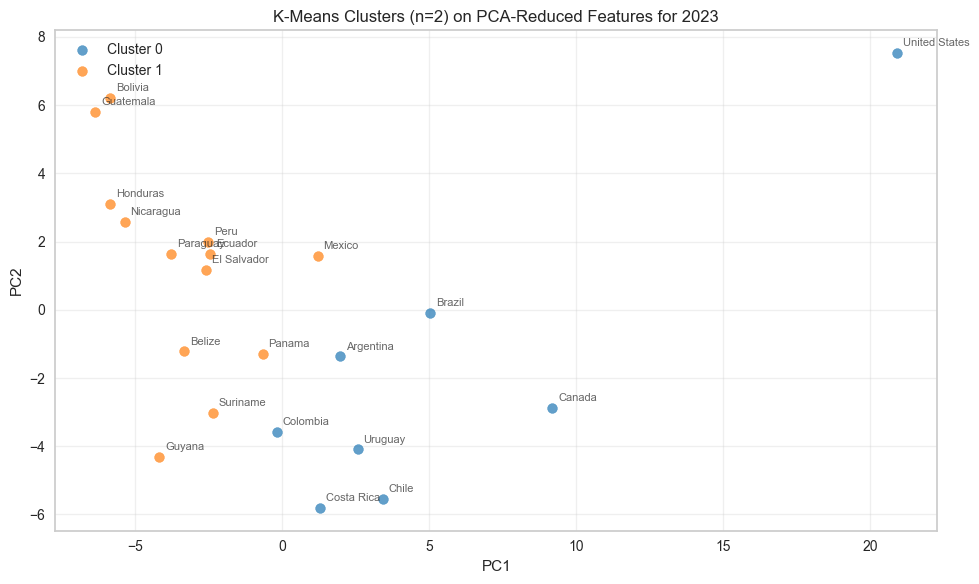

In [224]:
#Apply K-Means clustering on the selected principal components
n_clusters = visualizer_silhouette.elbow_value_  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_selected)
df_latest['cluster'] = cluster_labels

#Visualize clusters in the space of the first two principal components
plt.figure(figsize=(10, 6))
colors = plt.get_cmap('tab10')

for label in range(n_clusters):
    mask = cluster_labels == label
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=50,
        alpha=0.7,
        color=colors(label),
        label=f'Cluster {label}'
    )

offset = 0.2
for i in range(X_pca.shape[0]):
    plt.text(
        X_pca[i, 0] + offset, X_pca[i, 1] + offset,
        df_latest['country'].iloc[i],
        fontsize=8,
        alpha=0.7
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'K-Means Clusters (n={n_clusters}) on PCA-Reduced Features for {target_year}')
plt.legend(loc='best')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


**Answer to the third question:** The United States is far from all other countries, even within Cluster 0, followed by Canada. This indicates that these countries have very distinct features compared to the others. This fact suggests that the United States and Canada has stronger indicators relative to other countries as expected.

Cluster 0 appears to represent higher-performing or more developed nations, while Cluster 1 groups less developed or similarly smaller economies closer together.

Since we used a small number of clusters, it is expected that our clustering results in good separation between clusters and interpretability.